In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from scipy.stats import spearmanr
from joblib import Parallel, delayed
import warnings
import gc
import matplotlib.pyplot as plt
import argparse
from tqdm.auto import tqdm
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

In [2]:
output_folder = "/home/mzo5929/Keerthana/grnInference/plots/network_plots_median/"

In [21]:
# --- Helpers ---
def make_reds_blues_colormap():
    reds = plt.cm.Reds(np.linspace(1, 0, 128))   # deep red → white
    blues = plt.cm.Blues(np.linspace(0, 1, 128)) # white → deep blue
    colors = np.vstack((reds, blues))
    return LinearSegmentedColormap.from_list('RedsBlues', colors)

def shrink_arrow_endpoints(x1, y1, x2, y2, shrink_source=0.2, shrink_target=0.2, lateral_offset=0.0, scaled_shrink_val = 0.25):
    dx, dy = x2 - x1, y2 - y1
    dist = np.hypot(dx, dy)

    if dist == 0:
        return (x1, y1), (x2, y2)

    scaled_shrink = scaled_shrink_val * dist  # 25% of distance, adjust as needed
    shrink_source = scaled_shrink
    shrink_target = scaled_shrink*0.8

    ux, uy = dx / dist, dy / dist
    orth_x, orth_y = -uy, ux
    x1_off = x1 + shrink_source * ux + lateral_offset * orth_x
    y1_off = y1 + shrink_source * uy + lateral_offset * orth_y
    x2_off = x2 - shrink_target * ux + lateral_offset * orth_x
    y2_off = y2 - shrink_target * uy + lateral_offset * orth_y
    return (x1_off, y1_off), (x2_off, y2_off)

def flat_t_head_arrow(start, end, color='red', linewidth=2, rad=0.2, abs_weight=0.5, ax=None):
    """Draw repression arrow with T-head scaled by abs_weight."""
    arrow = FancyArrowPatch(
        start, end,
        connectionstyle=f"arc3,rad={rad}",
        arrowstyle='-',
        color=color,
        linewidth=linewidth,
        zorder=1
    )
    ax.add_patch(arrow)

    x1, y1 = start
    x2, y2 = end
    dx, dy = x2 - x1, y2 - y1
    dist = np.hypot(dx, dy)
    if dist == 0:
        return

    ux, uy = dx / dist, dy / dist
    tx, ty = x2, y2
    px, py = -uy, ux

    # Scale T-head size with abs_weight (capped)
    t_len = 0.03 + 0.07 * min(abs_weight, 1.0)
    t_xs = [tx - px * t_len, tx + px * t_len]
    t_ys = [ty - py * t_len, ty + py * t_len]
    ax.plot(t_xs, t_ys, color=color, linewidth=linewidth, solid_capstyle='round', zorder=2)

def polygon_layout(gene_list, radius=1.0):
    n = len(gene_list)
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    return {
        gene_list[i]: (radius * np.cos(angle), radius * np.sin(angle))
        for i, angle in enumerate(angles)
    }

# --- Main Plot Function ---
def plot_gene_correlation_network(correlation_matrix, gene_list, title=None, norm=None, cmap=None):
    DG = nx.DiGraph()
    for gene in gene_list:
        DG.add_node(gene)

    # Add edges with weights
    for g1 in gene_list:
        self_corr = correlation_matrix.loc[g1, g1]
        if self_corr == 0 or np.isnan(self_corr):
            continue
        for g2 in gene_list:
            if g1 == g2:
                continue
            raw_weight = correlation_matrix.loc[g1, g2]
            if pd.isnull(raw_weight):
                continue
            if abs(raw_weight) > 0.02:
                DG.add_edge(g1, g2, weight=raw_weight / self_corr)

    # Node colors
    node_colors = np.array([correlation_matrix.loc[g, g] for g in gene_list])

    # If norm/cmap not provided, determine automatically
    if norm is None or cmap is None:
        all_vals = list(node_colors) + [DG[u][v]['weight'] for u, v in DG.edges()]
        if len(all_vals) == 0:
            all_vals = [0]
        min_val, max_val = min(all_vals), max(all_vals)

        # if min_val >= 0:
        #     vmin, vmax = 0, max_val
        #     cmap = plt.cm.Blues
        # elif max_val <= 0:
        #     vmin, vmax = min_val, 0
        #     cmap = plt.cm.Reds
        # else:
        v = 1
        vmin, vmax = -v, v
        cmap = make_reds_blues_colormap()

        norm = Normalize(vmin=vmin, vmax=vmax)

    node_rgba = cmap(norm(node_colors))
    node_rgba[:, -1] = 0.8

    # Draw graph
    print(gene_list)
    if len(gene_list) > 2:
        # pos = nx.spring_layout(DG, seed=42)
        pos = polygon_layout(gene_list, radius=max(2, len(gene_list) / 2))
        scaled_shrink_val = 0.15
    else: 
        # Force horizontal alignment
        pos = {
            gene_list[0]: (0, 0),
            gene_list[1]: (1, 0)
        }
        scaled_shrink_val = 0.25

    fig, ax = plt.subplots(figsize=(9, 9))
    nx.draw_networkx_nodes(DG, pos, ax=ax, node_color=node_rgba, node_size=6000,
                           edgecolors='black', linewidths=1.5)
                           
    labels = {
    node: chr(64 + int(node.replace("gene_", "")))  # 1→A, 2→B, etc.
    for node in DG.nodes()
    }

    nx.draw_networkx_labels(DG, pos, labels=labels, font_size=16, ax=ax)

    # Draw edges
    for u, v in DG.edges():
        weight = DG[u][v]['weight']
        color = cmap(norm(weight))
        abs_weight = abs(weight)

        x1, y1 = pos[u]
        x2, y2 = pos[v]
    
        # Automatic offset for bidirectional edges
        offset = -0.15 if DG.has_edge(v, u) else 0.0
        rad = 0.2 if DG.has_edge(v, u) else 0.0
        start, end = shrink_arrow_endpoints(x1, y1, x2, y2, lateral_offset=offset, scaled_shrink_val = scaled_shrink_val)

        if weight > 0:
            arrow = FancyArrowPatch(
                start, end,
                connectionstyle=f'arc3,rad={rad}',
                arrowstyle='->, head_length=0.8, head_width=0.6',
                mutation_scale=20 + abs_weight * 10,
                color=color,
                linewidth=max(abs_weight * 10, 1.0),
                zorder=1
            )
            ax.add_patch(arrow)
        else:
            flat_t_head_arrow(start, end, color=color,
                              linewidth=max(abs_weight * 10, 1.0),
                              rad=rad, abs_weight=abs_weight, ax=ax)

    # Colorbar
    # sm = ScalarMappable(norm=norm, cmap=cmap)
    # cbar = fig.colorbar(sm, ax=ax)
    # cbar.set_label('Correlation (negative → red, positive → blue)', fontsize=12)

    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.axis('off')
    # --- Adjust margins to keep everything in frame ---
    if len(pos) > 0:
        x_vals, y_vals = zip(*pos.values())
        if all(np.isfinite(x_vals)) and all(np.isfinite(y_vals)):
            x_range = max(x_vals) - min(x_vals)
            y_range = max(y_vals) - min(y_vals)
            x_margin = 0.3 * x_range if x_range > 0 else 1
            y_margin = 0.3 * y_range if y_range > 0 else 1
            ax.set_xlim(min(x_vals) - x_margin, max(x_vals) + x_margin)
            ax.set_ylim(min(y_vals) - y_margin, max(y_vals) + y_margin)

    plt.tight_layout()
    
    # return fig, ax, sm
    # REMOVE this inside the function
    # sm = ScalarMappable(norm=norm, cmap=cmap)
    # cbar = fig.colorbar(sm, ax=ax)
    if len(gene_list) == 2:
        ax.set_xlim(-0.5, len(gene_list) - 0.5)
        ax.set_ylim(-0.5, 0.5)
        ax.set_aspect('equal')  # keeps arrows straight
        plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
    else:
        plt.subplots_adjust(left=0.02, right=0.98, top=0.95, bottom=0.05)
    return fig, ax, ScalarMappable(norm=norm, cmap=cmap)



In [4]:
# ----- Step 1: Compute correlations -----
def calculate_gene_gene_corr(df, gene_list):
    correlations = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr = spearmanr(df[f"{gene_1}_mRNA"], df[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}-{gene_2}"] = corr
    return correlations

from scipy.stats import spearmanr
import pandas as pd

def calculate_pair_correlation(rep_0, rep_1, gene_list):
    # Reset indices ONCE (do not do it inside the loop)
    rep_0 = rep_0.reset_index(drop=True)
    rep_1 = rep_1.reset_index(drop=True)

    # Compute pairwise correlations
    correlations = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            delta_1 = rep_0[f"{gene_1}_mRNA"] - rep_1[f"{gene_1}_mRNA"]
            delta_2 = rep_0[f"{gene_2}_mRNA"] - rep_1[f"{gene_2}_mRNA"]
            corr = spearmanr(delta_1, delta_2).correlation
            correlations[f"{gene_1}-{gene_2}"] = corr
    return correlations


def dict_to_matrix(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("-")
        matrix.loc[g1, g2] = value
    return matrix



In [5]:
def dict_to_matrix_directional(correlation_dict, gene_list):
    matrix = pd.DataFrame(index=gene_list, columns=gene_list, dtype=float)
    for key, value in correlation_dict.items():
        g1, g2 = key.split("->")
        matrix.loc[g1, g2] = value
    return matrix

#Calculate correlation between different genes between two time points - y-axis is t1 and x-axis is t2
def calculate_cross_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2, gene_list):
    correlations = {}
    correlations_normalised = {}
    for gene_1 in gene_list:
        for gene_2 in gene_list:
            corr_t1_t2 = spearmanr(rep_0_t1[f"{gene_1}_mRNA"], rep_1_t2[f"{gene_2}_mRNA"]).correlation
            correlations[f"{gene_1}->{gene_2}"] = corr_t1_t2
    return correlations

In [6]:
def create_network_plot(path_to_simulation, df = None):
    if df is None:
        df = pd.read_csv(path_to_simulation)
    if df['time_step'].nunique() == 49:
        t1 = 5
        t2 = 10
    else:
        t1 = 5*4
        t2 = 10*4
    # else:
    #     raise "Size of time_step unknown"
    singleTime_df = df[df['time_step'] == t1]
    rep_0_t1 = singleTime_df[singleTime_df['replicate'] == 1]
    rep_1_t1 = singleTime_df[singleTime_df['replicate'] == 2]
    
    singleTime_df = df[df['time_step'] == t2]
    rep_0_t2 = singleTime_df[singleTime_df['replicate'] == 1]
    rep_1_t2 = singleTime_df[singleTime_df['replicate'] == 2]
    n_genes = len(
    set('_'.join(col.split('_')[:2]) for col in df.columns if '_mRNA' in col)
    )

    gene_list = [f"gene_{i}" for i in np.arange(1, n_genes + 1)]
    print(gene_list)

    # Compute correlation matrix for twin differences at time t1 and time t2
    #time t1
    gene_gene_corr_t1 = calculate_gene_gene_corr( df[(df['time_step'] == t1)], gene_list)
    gene_gene_corr_matrix_t1 = dict_to_matrix(gene_gene_corr_t1, gene_list)
    # print("gene_gene_corr_matrix_t1")
    # print(gene_gene_corr_matrix_t1)
    # BEGIN: Check non-diagonal elements greater than 0.05 abs
    non_diagonal_elements = gene_gene_corr_matrix_t1.values[~np.eye(gene_gene_corr_matrix_t1.shape[0], dtype=bool)]
    greater_than_threshold = non_diagonal_elements[np.abs(non_diagonal_elements) > 0.04]

    # Find exact cells greater than 0.05
    greater_than_threshold_indices = np.argwhere(np.abs(gene_gene_corr_matrix_t1.values) > 0.04)
    for i, j in greater_than_threshold_indices:
        if i!=j:
            print(f"Interaction ({gene_gene_corr_matrix_t1.index[i]}, {gene_gene_corr_matrix_t1.columns[j]}) = {gene_gene_corr_matrix_t1.values[i, j]}")

    correlation_dict_t1 = calculate_pair_correlation(rep_0_t1, rep_1_t1, gene_list)
    twin_correlation_matrix_t1 = dict_to_matrix(correlation_dict_t1, gene_list)
    # print("twin_correlation_matrix_t1")
    # print(twin_correlation_matrix_t1)
    correlation_dict_t2 = calculate_pair_correlation(rep_0_t2, rep_1_t2, gene_list)
    twin_correlation_matrix_t2 = dict_to_matrix(correlation_dict_t2, gene_list)
    # print("twin_correlation_matrix_t2")
    # print(twin_correlation_matrix_t2)
    random_correlation_dict_t1 = calculate_pair_correlation(rep_0_t1, rep_1_t1.sample(frac=1).reset_index(drop=True), gene_list)
    random_correlation_matrix_t1= dict_to_matrix(random_correlation_dict_t1, gene_list)
    # print("random_correlation_matrix_t1")
    # print(random_correlation_matrix_t1)
    #If there is regulation, then use cross-correlation
    asymmetric_correlations = calculate_cross_correlation(rep_0_t1, rep_1_t1, rep_0_t2, rep_1_t2, gene_list)
    correlation_matrix_directional = dict_to_matrix_directional(asymmetric_correlations, gene_list)
    for i in range(len(gene_list)):
        for j in range(len(gene_list)):
            if (i, j) not in greater_than_threshold_indices:
                correlation_matrix_directional.iloc[i, j] = 0
            if abs(random_correlation_matrix_t1.iloc[i, j]/twin_correlation_matrix_t1.iloc[i, j]) >=25:
                print(f"Two states for {gene_list[i]} and {gene_list[j]}")
                if (twin_correlation_matrix_t2.iloc[i, j] - twin_correlation_matrix_t1.iloc[i, j])/twin_correlation_matrix_t1.iloc[i, j] > 0.1:
                    print(f"Two states and regulation for {gene_list[i]} and {gene_list[j]}")
                else:
                    correlation_matrix_directional.iloc[i, j] = 0

    #Compare between twin and random - if ratio < 20: print two states

    # Compare between twins at t1 and t2 - if t2 > t1, regulation

    fig, ax, sm = plot_gene_correlation_network(correlation_matrix_directional, gene_list)
    # plt.show()
    return gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm

In [7]:
data = {}

In [14]:
gene_gene_corr_matrix_t1

,gene_1,gene_2,gene_3
gene_1,1.000000,-0.006414,0.013538
gene_2,-0.006414,1.000000,0.024399
gene_3,0.013538,0.024399,1.000000


['gene_1', 'gene_2']
Interaction (gene_1, gene_2) = 0.35610428435902747
Interaction (gene_2, gene_1) = 0.35610428435902747
Two states for gene_1 and gene_2
Two states for gene_2 and gene_1
['gene_1', 'gene_2']


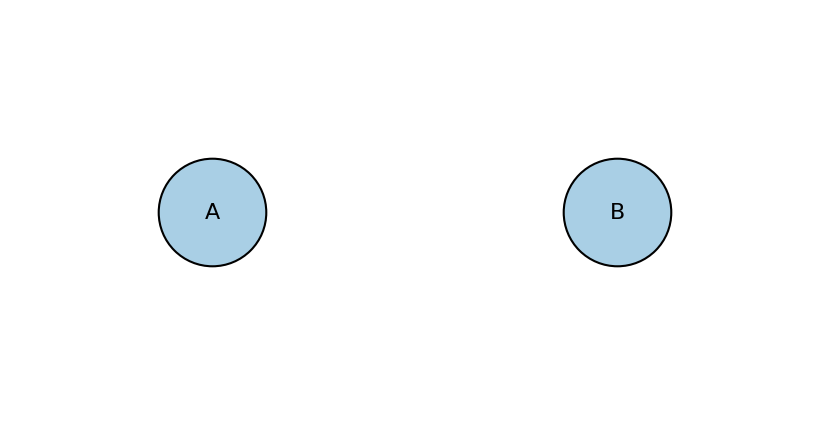

In [16]:
#A->B
df_state_1 = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_rows_25_26_17072025_132645_ncells_10000_A_B_only_lower_k_on_17_576467bf.csv")
df_state_2 = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_rows_27_28_17072025_124153_ncells_10000_A_B_only_higher_k_on_13_a399c51d.csv")
df_state_3 = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_rows_0_1_16072025_234405_ncells_10000_A_B_3_a4fb82ac.csv")
df_state_1 = df_state_1[(df_state_1['time_step'] == 5*4 )| (df_state_1['time_step'] == 10*4)]
df_state_2 = df_state_2[(df_state_2['time_step'] == 5*4 )| (df_state_2['time_step'] == 10*4)]
df_state_3 = df_state_3[(df_state_3['time_step'] == 5*4 )| (df_state_3['time_step'] == 10*4)]
df = pd.concat([df_state_1, df_state_2, df_state_3])
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_0_1_14072025_175926_ncells_10000_A_to_B_9c7f0cd0.csv"
gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim, df = df)

data['A_to_B'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}
# fig.savefig(f"{output_folder}/A_to_B_median.svg", format='svg')
# fig.savefig(f"{output_folder}/A_to_B_median.png", format='png')

In [23]:
correlation_matrix_directional

,gene_1,gene_2,gene_3
gene_1,0.075215,-0.012397,0.038459
gene_2,0.002851,0.080085,0.027307
gene_3,0.025098,0.003316,0.135431


['gene_1', 'gene_2', 'gene_3']
Interaction (gene_1, gene_3) = 0.04681965336429911
Interaction (gene_3, gene_1) = 0.04681965336429911
['gene_1', 'gene_2', 'gene_3']


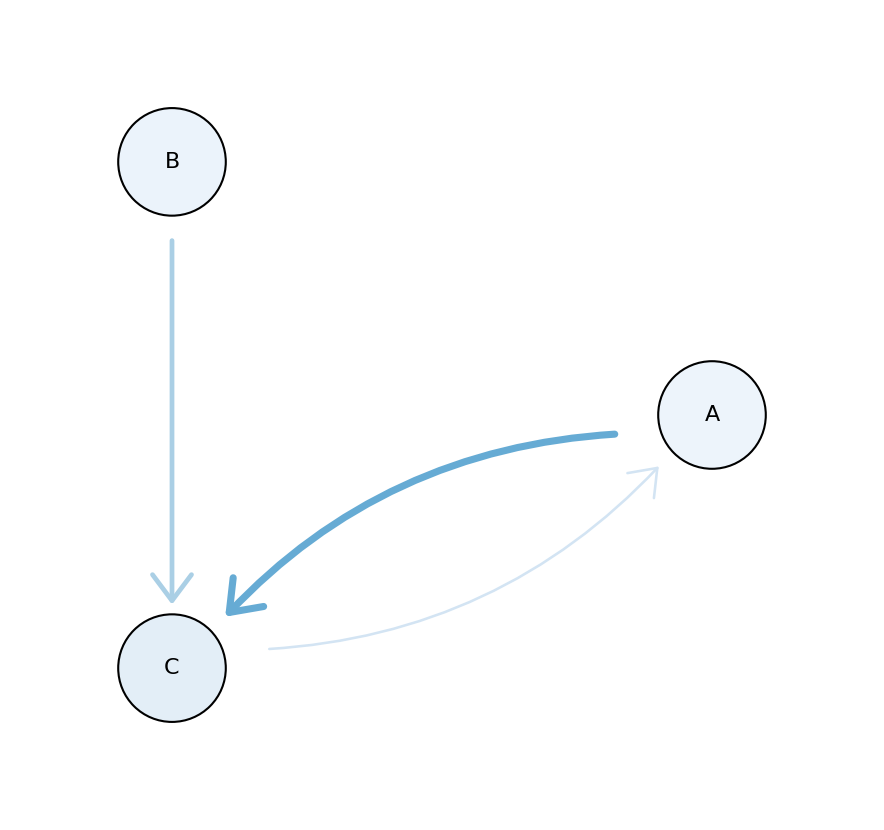

In [22]:
#A->B
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_0_1_2_16072025_140816_ncells_10000_A_to_C_B_to_C_55d9c31b.csv"
gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim)

data['A_to_B'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}
# fig.savefig(f"{output_folder}/A_to_B_median.svg", format='svg')
# fig.savefig(f"{output_folder}/A_to_B_median.png", format='png')

In [ ]:
#No regulation
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_0_1_14072025_220943_ncells_10000_A_B_261640e4.csv"
gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim)

data['A_B_median'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}
fig.savefig(f"{output_folder}/network_A_B_median.svg", format='svg')
fig.savefig(f"{output_folder}/network_A_B_median.png", format='png')

In [ ]:
correlation_matrix_directional

In [ ]:
correlation_matrix_directional

In [ ]:
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_0_1_14072025_224456_ncells_10000_A_and_B_9f4b14e4.csv"
gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim)

data['A_and_B_median'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}
fig.savefig(f"{output_folder}/network_A_and_B_median.svg", format='svg')
fig.savefig(f"{output_folder}/network_A_and_B_median.png", format='png')

In [ ]:
#Repression
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_6_7_14072025_190938_ncells_10000_A_rep_B_68dd1f7d.csv"
gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim)

data['A_rep_B'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}
print("correlation_matrix_directional")
print(correlation_matrix_directional)
fig.savefig(f"{output_folder}/network_A_rep_B_median.svg", format='svg')
fig.savefig(f"{output_folder}/network_A_rep_B_median.png", format='png')

In [ ]:
#Cascade
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_10_11_12_14072025_233548_ncells_10000_A_to_B_to_C_73acd23c.csv"
gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim)
print("correlation_matrix_directional")
print(correlation_matrix_directional)
data['A_to_B_to_C'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}
fig.savefig(f"{output_folder}/network_A_to_B_to_C_median.svg", format='svg')
fig.savefig(f"{output_folder}/network_A_to_B_to_C_median.png", format='png')

['gene_1', 'gene_2', 'gene_3']
Interaction (gene_1, gene_2) = 0.05090413550818718
Interaction (gene_2, gene_1) = 0.05090413550818718
Interaction (gene_2, gene_3) = 0.10954723255941126
Interaction (gene_3, gene_2) = 0.10954723255941126
Two states for gene_2 and gene_3
Two states and regulation for gene_2 and gene_3
Two states for gene_3 and gene_2
Two states and regulation for gene_3 and gene_2
['gene_1', 'gene_2', 'gene_3']
correlation_matrix_directional
          gene_1    gene_2    gene_3
gene_1  0.069517  0.049237  0.067803
gene_2  0.012287  0.174568  0.105849
gene_3  0.019980  0.102104  0.151206


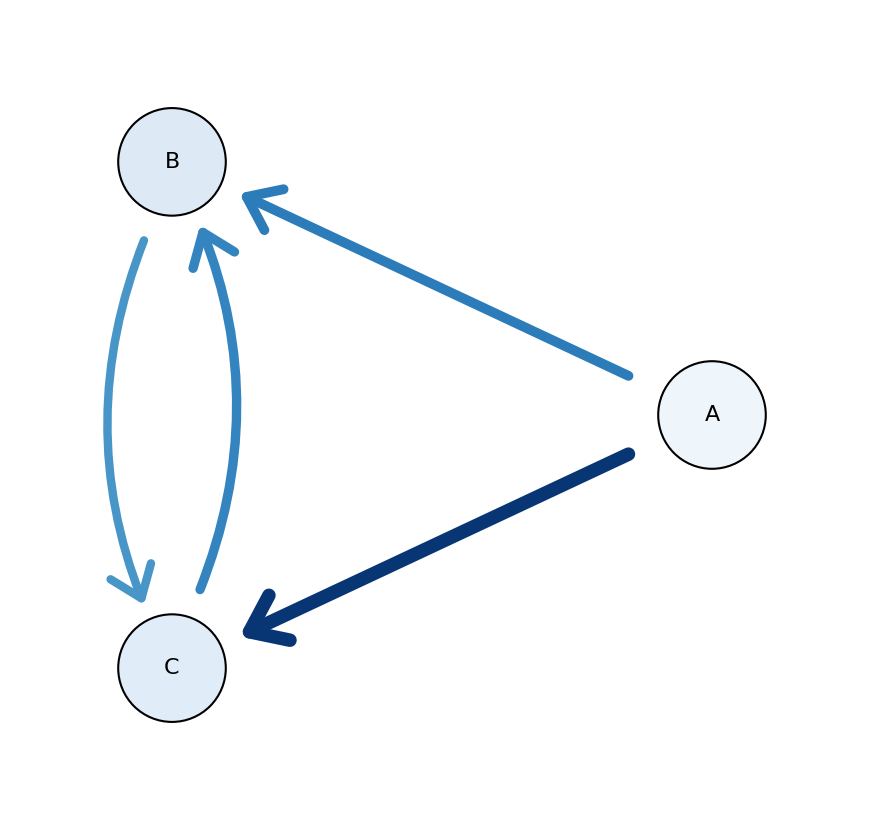

In [24]:
#Fan out
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_10_11_12_15072025_002815_ncells_10000_A_to_B_A_to_C_172ed241.csv"
gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim)

data['A_to_B_A_to_C'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}
print("correlation_matrix_directional")
print(correlation_matrix_directional)
fig.savefig(f"{output_folder}/network_A_to_B_A_to_C_median.svg", format='svg')
fig.savefig(f"{output_folder}/network_A_to_B_A_to_C_median.png", format='png')

In [ ]:
#Toggle switch
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_19_20_15072025_130426_ncells_10000_A_rep_B_B_rep_A_1d427973.csv"
gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim)

data['A_rep_B_B_rep_A'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}
print("correlation_matrix_directional")
print(correlation_matrix_directional)
fig.savefig(f"{output_folder}/network_A_rep_B_B_rep_A_median.svg", format='svg')
fig.savefig(f"{output_folder}/network_A_rep_B_B_rep_A_median.png", format='png')

In [ ]:
#2 states
df_state1 = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_rows_25_26_16072025_093653_ncells_10000_A_B_only_lower_k_on_03db176a.csv")
df_state2 = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_rows_27_28_16072025_100413_ncells_10000_A_B_only_higher_k_on_aa330570.csv")
df = pd.concat([df_state1, df_state2])
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_0_1_14072025_220943_ncells_10000_A_B_261640e4.csv"

gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim, df = df)

# fig.savefig(f"{output_folder}/network_A_B_2_states.svg", format='svg')
# fig.savefig(f"{output_folder}/network_A_B_2_states.png", format='png')

data['A_B_2_states'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}

In [ ]:
df['time_step'].nunique()

In [ ]:
#2 states
df_state1 = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_rows_25_26_16072025_102511_ncells_10000_A_to_B_only_lower_k_on_f91be39b.csv")
df_state2 = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_rows_27_28_16072025_131623_ncells_10000_A_to_B_only_higher_k_on_e469aed7.csv")
# df_state1 = df_state1[(df_state1['time_step'] == 5*4)| (df_state1['time_step'] == 10*4)]
# df_state2 = df_state2[(df_state2['time_step'] == 5*4)| (df_state2['time_step'] == 10*4)]
df = pd.concat([df_state1, df_state2])
path_to_sim = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_row_0_1_14072025_220943_ncells_10000_A_B_261640e4.csv"

gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(path_to_sim, df = df)

# fig.savefig(f"{output_folder}/network_A_to_B_2_states.svg", format='svg')
# fig.savefig(f"{output_folder}/network_A_to_B_2_states.png", format='png')

data['A_to_B_2_states'] = {
    'directional': correlation_matrix_directional,
    'gene_gene': gene_gene_corr_matrix_t1,
    'random_t1': random_correlation_matrix_t1,
    'twin_t1': twin_correlation_matrix_t1,
    'twin_t2': twin_correlation_matrix_t2
}

In [72]:
from matplotlib.cm import ScalarMappable

# sm should be defined like this:
# sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Ensures the colorbar knows it has data
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Correlation", fontsize=12)  # optional
plt.show()


## Plots for panel 2c


In [142]:
results = {}

In [ ]:
df = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations/df_rows_0_1_16072025_211315_ncells_10000_A_to_B_1_b33bf4a1.csv")
df['time_step'].nunique()

In [ ]:
import os
import glob
import numpy as np
import pandas as pd

results = {
    'A_to_B_2_states': {
        'directional': [],
        'gene_gene': [],
        'random_t1': [],
        'twin_t1': [],
        'twin_t2': []
    },
    'A_B_2_states': {
        'directional': [],
        'gene_gene': [],
        'random_t1': [],
        'twin_t1': [],
        'twin_t2': []
    }
}

sim_folder = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations"
pattern = os.path.join(sim_folder, "df_rows_0_1_*_ncells_10000_A_to_B*.csv")

# --- Collect all files ---
sim_files = sorted(glob.glob(pattern))

# --- Storage ---
data = {}  # stores individual files

# --- Iterate over all simulations ---
for sim_file in sim_files:
    fname = os.path.basename(sim_file)
    sim_type = "A_to_B"

    print(f"Processing [{sim_type}]: {fname}")

    gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, \
        random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(sim_file)

    # Store individual result
    data[fname] = {
        'directional': correlation_matrix_directional,
        'gene_gene': gene_gene_corr_matrix_t1,
        'random_t1': random_correlation_matrix_t1,
        'twin_t1': twin_correlation_matrix_t1,
        'twin_t2': twin_correlation_matrix_t2
    }

    # Ensure type exists in results
    if sim_type not in results:
        results[sim_type] = {
            'directional': [],
            'gene_gene': [],
            'random_t1': [],
            'twin_t1': [],
            'twin_t2': []
        }

    # Append to type-specific list
    results[sim_type]['directional'].append(correlation_matrix_directional)
    results[sim_type]['gene_gene'].append(gene_gene_corr_matrix_t1)
    results[sim_type]['random_t1'].append(random_correlation_matrix_t1)
    results[sim_type]['twin_t1'].append(twin_correlation_matrix_t1)
    results[sim_type]['twin_t2'].append(twin_correlation_matrix_t2)


In [ ]:
# --- Iterate over all simulations ---
sim_folder = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations"
pattern = os.path.join(sim_folder, "df_rows_0_1_*_ncells_10000_A_B*.csv")
sim_files = sorted(glob.glob(pattern))
for sim_file in sim_files:
    fname = os.path.basename(sim_file)
    sim_type = "A_B"

    print(f"Processing [{sim_type}]: {fname}")

    gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, \
        random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(sim_file)

    # Store individual result
    data[fname] = {
        'directional': correlation_matrix_directional,
        'gene_gene': gene_gene_corr_matrix_t1,
        'random_t1': random_correlation_matrix_t1,
        'twin_t1': twin_correlation_matrix_t1,
        'twin_t2': twin_correlation_matrix_t2
    }

    # Ensure type exists in results
    if sim_type not in results:
        results[sim_type] = {
            'directional': [],
            'gene_gene': [],
            'random_t1': [],
            'twin_t1': [],
            'twin_t2': []
        }

    # Append to type-specific list
    results[sim_type]['directional'].append(correlation_matrix_directional)
    results[sim_type]['gene_gene'].append(gene_gene_corr_matrix_t1)
    results[sim_type]['random_t1'].append(random_correlation_matrix_t1)
    results[sim_type]['twin_t1'].append(twin_correlation_matrix_t1)
    results[sim_type]['twin_t2'].append(twin_correlation_matrix_t2)


In [13]:
import re
sim_folder = "/home/mzo5929/Keerthana/grnInference/simulation_data/median_parameter_simulations/simulations"
pattern = os.path.join(sim_folder, "df_rows_*_ncells_10000_*only_*_k_on_*.csv")

# --- Collect files ---
files = sorted(glob.glob(pattern))

pairs = {}
for f in files:
    fname = os.path.basename(f)

    # Extract k_on number
    k_on_match = re.search(r"k_on_(\d+)_", fname)
    if not k_on_match:
        continue
    k_on_id = k_on_match.group(1)  # e.g., "10"

    # Extract simulation type (A_to_B or A_B)
    sim_type_match = re.search(r"_(A_to_B|A_B)_", fname)
    sim_type = sim_type_match.group(1) if sim_type_match else "unknown"

    key = (sim_type, k_on_id)
    pairs.setdefault(key, {'lower': None, 'higher': None})

    if "only_lower_k_on" in fname:
        pairs[key]['lower'] = f
    elif "only_higher_k_on" in fname:
        pairs[key]['higher'] = f

for (sim_type, k_on_id), pair in pairs.items():
    if pair['lower'] and pair['higher']:
        print(f"\nProcessing 2-state pair for {sim_type}, k_on_{k_on_id}:\n  {pair['lower']}\n  {pair['higher']}")

        # --- Load and filter ---
        df_lower = pd.read_csv(pair['lower'])
        df_higher = pd.read_csv(pair['higher'])
        df_lower = df_lower[df_lower['time_step'].isin([5*4, 10*4])]
        df_higher = df_higher[df_higher['time_step'].isin([5*4, 10*4])]

        df_2_states = pd.concat([df_lower, df_higher], ignore_index=True)

        path_to_sim = pair['lower']

        # --- Run network plot ---
        gene_gene_corr_matrix_t1, twin_correlation_matrix_t1, twin_correlation_matrix_t2, \
            random_correlation_matrix_t1, correlation_matrix_directional, fig, ax, sm = create_network_plot(
                path_to_sim, df=df_2_states
            )

        # --- Append to results for averaging ---
        key = f"{sim_type}_2_states"
        results[key]['directional'].append(correlation_matrix_directional)
        results[key]['gene_gene'].append(gene_gene_corr_matrix_t1)
        results[key]['random_t1'].append(random_correlation_matrix_t1)
        results[key]['twin_t1'].append(twin_correlation_matrix_t1)
        results[key]['twin_t2'].append(twin_correlation_matrix_t2)

print("\n✅ All 2-state pairs processed and appended to results!")


In [14]:
averages = {}
stds = {}

for sim_type, sim_data in results.items():
    averages[sim_type] = {}
    stds[sim_type] = {}
    for key, matrices in sim_data.items():
        if isinstance(matrices[0], pd.DataFrame):
            averages[sim_type][key] = sum(matrices) / len(matrices)
            stds[sim_type][key] = pd.concat(matrices).groupby(level=0).std()  # row-wise std
        else:
            arr = np.stack(matrices)
            averages[sim_type][key] = np.mean(arr, axis=0)
            stds[sim_type][key] = np.std(arr, axis=0)


In [15]:
gc.collect()

105038

In [17]:
type(results)

dict

In [21]:
import json
import pandas as pd

def make_json_serializable(obj):
    """Recursively convert DataFrames and NumPy arrays to lists."""
    if isinstance(obj, pd.DataFrame):
        return obj.values.tolist()
    elif isinstance(obj, (list, tuple)):
        return [make_json_serializable(x) for x in obj]
    elif isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    else:
        return obj

serializable_results = make_json_serializable(results)

output_file = "/home/mzo5929/Keerthana/grnInference/analysisData/results.json"
with open(output_file, "w") as f:
    json.dump(serializable_results, f, indent=4)

print(f"✅ Results saved to {output_file}")


✅ Results saved to /home/mzo5929/Keerthana/grnInference/analysisData/results.json


/tmp/ipykernel_1060524/3075027306.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(all_values, labels=sim_types_to_plot, patch_artist=True, showfliers=False)


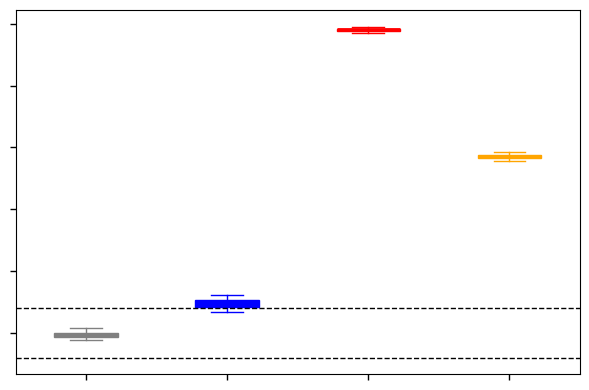

In [22]:
import matplotlib.pyplot as plt
import numpy as np

sim_types_to_plot = ['A_B', 'A_to_B', 'A_B_2_states', 'A_to_B_2_states']
colors = ['grey', 'blue', 'red', 'orange']

# Collect all iteration values for iloc[0,1]
all_values = []
for sim_type in sim_types_to_plot:
    vals = [mat.iloc[0, 1] for mat in results[sim_type]['gene_gene']]
    all_values.append(vals)

# --- Boxplot ---
plt.figure(figsize=(6, 4))
box = plt.boxplot(all_values, labels=sim_types_to_plot, patch_artist=True, showfliers=False)

# ✅ Style each component with matching color
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)  # box outline color

for whisker, color in zip(box['whiskers'], [c for c in colors for _ in (0, 1)]):
    whisker.set_color(color)

for cap, color in zip(box['caps'], [c for c in colors for _ in (0, 1)]):
    cap.set_color(color)

for median, color in zip(box['medians'], colors):
    median.set_color(color)
    median.set_linewidth(2)

plt.axhline(0.04, linestyle="--", color="black", linewidth=1)
plt.axhline(-0.04, linestyle="--", color="black", linewidth=1)

plt.tick_params(
    axis='both',
    which='both',
    bottom=True, top=False, left=True, right=False,
    labelbottom=False, labelleft=False,
    length=4, width=1
)

plt.tight_layout()
plt.savefig(f"{output_folder}/gene_gene_corr.png", format="png")
plt.savefig(f"{output_folder}/gene_gene_corr.svg", format="svg")
plt.show()


/tmp/ipykernel_1060524/1118729057.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(all_ratios, labels=sim_types_to_plot, patch_artist=True, showfliers=False)


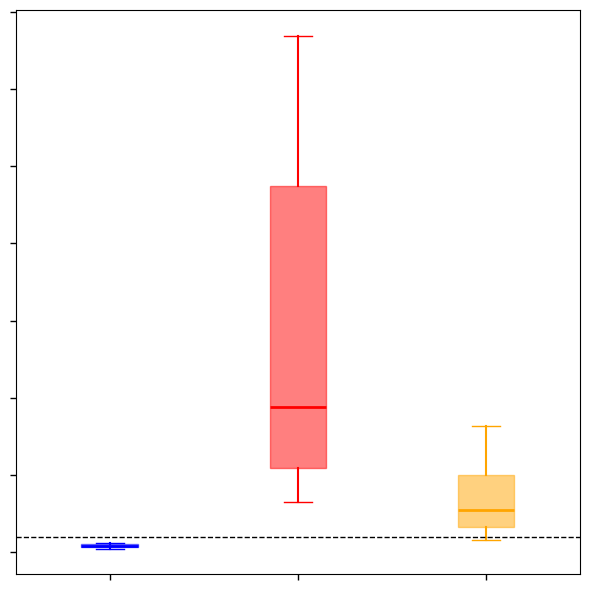

In [23]:
import numpy as np
import matplotlib.pyplot as plt

sim_types_to_plot = ['A_to_B', 'A_B_2_states', 'A_to_B_2_states']
colors = ['blue', 'red', 'orange']

# --- Collect ratios ---
all_ratios = []
for sim_type in sim_types_to_plot:
    ratios = []
    for r, t in zip(results[sim_type]['random_t1'], results[sim_type]['twin_t1']):
        rand_val = r.iloc[0, 1]
        twin_val = t.iloc[0, 1]
        if twin_val != 0:
            ratios.append(abs(rand_val / twin_val))
        else:
            ratios.append(np.nan)
    all_ratios.append([v for v in ratios if not np.isnan(v)])

# --- Plot ---
plt.figure(figsize=(6, 6))
box = plt.boxplot(all_ratios, labels=sim_types_to_plot, patch_artist=True, showfliers=False)

# ✅ Color each component consistently
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)      # box outline color
    patch.set_alpha(0.5)

for whisker, color in zip(box['whiskers'], [c for c in colors for _ in (0, 1)]):
    whisker.set_color(color)
    whisker.set_linewidth(1.5)

for cap, color in zip(box['caps'], [c for c in colors for _ in (0, 1)]):
    cap.set_color(color)

for median, color in zip(box['medians'], colors):
    median.set_color(color)
    median.set_linewidth(2)

plt.axhline(10, linestyle="--", color="black", linewidth=1)

# Optional log scale if ratios vary a lot
# plt.yscale('log')

plt.tick_params(
    axis='both',
    which='both',
    bottom=True, top=False, left=True, right=False,
    labelbottom=False, labelleft=False,
    length=4, width=1
)

plt.tight_layout()
plt.savefig(f"{output_folder}/random_vs_twin.png", format="png")
plt.savefig(f"{output_folder}/random_vs_twin.svg", format="svg")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sim_types_to_plot = ['A_to_B', 'A_B_2_states', 'A_to_B_2_states']
all_ratios = []
colors = ['blue', 'red', 'orange']
for sim_type in sim_types_to_plot:
    ratios = []
    for r, t in zip(results[sim_type]['random_t1'], results[sim_type]['twin_t1']):
        rand_val = r.iloc[0, 1]
        twin_val = t.iloc[0, 1]
        if twin_val != 0:
            ratios.append(abs(rand_val / twin_val))
        else:
            ratios.append(np.nan)  # or skip
    all_ratios.append(ratios)

all_ratios_cleaned = [[v for v in group if not np.isnan(v)] for group in all_ratios]

plt.figure(figsize=(6, 6))

# Boxplot
box = plt.boxplot(all_ratios_cleaned, labels=sim_types_to_plot, patch_artist=True, showfliers=False)

# Color each box
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)  # Set opacity to 50%

plt.axhline(10, linestyle="--", color="black", linewidth=1)
# plt.yscale('log')  # optional but recommended for wide dynamic range

plt.tight_layout()
plt.savefig(f"{output_folder}/random_vs_twin.png", format = "png")
plt.tick_params(
    axis='both',
    which='both',
    bottom=True, top=False, left=True, right=False,
    labelbottom=False, labelleft=False,  # Hides tick labels
    length=4, width=1
)
plt.tight_layout()
plt.savefig(f"{output_folder}/random_vs_twin.svg", format = "svg")
plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt

sim_types_to_plot = ['A_B_2_states', 'A_to_B_2_states']
colors = ['red', 'orange']

plt.figure(figsize=(6, 6))
x_positions = {'t1': 0.2, 't2': 0.8}  # shift away from the edges
mean_points = {}

for sim_type, color in zip(sim_types_to_plot, colors):
    t1_vals, t2_vals = [], []

    for t1, t2 in zip(results[sim_type]['twin_t1'], results[sim_type]['twin_t2']):
        t1_vals.append(t1.iloc[0, 1])
        t2_vals.append(t2.iloc[0, 1])

    # --- Jittered strip plot ---
    jitter_t1 = np.random.normal(x_positions['t1'], 0.03, size=len(t1_vals))
    jitter_t2 = np.random.normal(x_positions['t2'], 0.03, size=len(t2_vals))

    plt.scatter(jitter_t1, t1_vals, color=color, alpha=0.5, s=30)
    plt.scatter(jitter_t2, t2_vals, color=color, alpha=0.5, s=30)

    # --- Light individual connection lines ---
    for x1, y1, x2, y2 in zip(jitter_t1, t1_vals, jitter_t2, t2_vals):
        plt.plot([x1, x2], [y1, y2], color=color, alpha=0.2, linewidth=0.8)

    # --- Mean connection ---
    mean_t1, mean_t2 = np.mean(t1_vals), np.mean(t2_vals)
    mean_points[sim_type] = (mean_t1, mean_t2)

    plt.plot(
        [x_positions['t1'], x_positions['t2']],
        [mean_t1, mean_t2],
        color=color,
        linewidth=2.5,
        alpha=0.9
    )
    plt.scatter(
        [x_positions['t1'], x_positions['t2']],
        [mean_t1, mean_t2],
        color=color,
        s=80,
        edgecolor='black',
        zorder=3,
        label=f"{sim_type} mean"
    )

# --- Aesthetics ---
plt.xticks([0, 1], ['twin_t1', 'twin_t2'])
# plt.ylabel("Twin correlation")
plt.title("")
plt.grid(True, axis='y', alpha=0.3)
# plt.legend(loc='best')
plt.tight_layout()
plt.savefig(f"{output_folder}/change_in_twin_correlation.png", format = "png")
plt.tick_params(
    axis='both',
    which='both',
    bottom=True, top=False, left=True, right=False,
    labelbottom=False, labelleft=False,  # Hides tick labels
    length=4, width=1
)
plt.tight_layout()
plt.savefig(f"{output_folder}/change_in_twin_correlation.svg", format = "svg")
